# Working with 4D-STEM images for strain mapping

Notebooks prepared by Debangshu Mukherjee 

Email: [mukherjeed@ornl.gov](mailto:mukherjeed@ornl.gov) or [debangshu24@gmail.com](mailto:debangshu24@gmail.com)

This notebook will go through the steps on loading a nanobeam 4D-STEM dataset. We will find the region of interest, fit the diffraction disks, and then generate a strain map from the 4D-STEM NBED data.

The analysis demonstrated in this notebook uses the [**STEMTool**](https://github.com/pycroscopy/stemtool) package. We will also download the data that is hosted on Dropbox, so we first install the `stemtool` and the `wget` packages which may not be present inside Colab.

In [24]:
!pip install stemtool wget pymcr

## Load packages

Load the requisite packages to get started

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec as mpgs
import matplotlib as mpl
import numpy as np
import wget
import numba
import pymcr
from matplotlib_scalebar.scalebar import ScaleBar, SI_LENGTH_RECIPROCAL
from matplotlib.offsetbox import AnchoredText
import stemtool as st
import scipy.ndimage as scnd
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

I define some colors personally, but you can skip this if you want. This is entirely a personal artistic decision.

In [4]:
from matplotlib.colors import LinearSegmentedColormap as LSC
vl_cl = LSC.from_list('list', [(0, 0, 0), (0.557,0.267, 0.678),(1,1,1)], N=256)
bu_cl = LSC.from_list('list', [(0, 0, 0), (0.161,0.502, 0.725),(1,1,1)], N=256)
gr_cl = LSC.from_list('list', [(0, 0, 0), (0.153,0.682, 0.376),(1,1,1)], N=256)
yl_cl = LSC.from_list('list', [(0, 0, 0), (0.945,0.769, 0.059),(1,1,1)], N=256)
or_cl = LSC.from_list('list', [(0, 0, 0), (0.902,0.494, 0.133),(1,1,1)], N=256)
rd_cl = LSC.from_list('list', [(0, 0, 0), (0.906,0.298, 0.235),(1,1,1)], N=256)
lin_burd = LSC.from_list('list', [(0, 35/255, 156/255), (0.95,0.95, 0.95),(249/255,56/255,34/255)], N=256)

## Download the data

Download the data hosted on Dropbox through `wget`

In [5]:
!wget -O "4DSTEM_Strain.npz" https://www.dropbox.com/s/rcibqb1r7n47w2a/4DSTEM_Strain.npz?dl=0

--2020-12-08 20:25:35--  https://www.dropbox.com/s/rcibqb1r7n47w2a/4DSTEM_Strain.npz?dl=0
Resolving www.dropbox.com... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rcibqb1r7n47w2a/4DSTEM_Strain.npz [following]
--2020-12-08 20:25:35--  https://www.dropbox.com/s/raw/rcibqb1r7n47w2a/4DSTEM_Strain.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc063a0d55cf2c02e99bac67c33d.dl.dropboxusercontent.com/cd/0/inline/BEt3o3XxSBqTKL9uK3yjyL8PQDEi7COyMavEimytnvvFog9SOgXUZPS9t-2FMvtqsErjpwcdpLE0bjLMIBCmXhsHceMVZmzgsMLgbpGBVndX3w_CNB1n_sJhBfP6cVA5g8Y/file# [following]
--2020-12-08 20:25:35--  https://uc063a0d55cf2c02e99bac67c33d.dl.dropboxusercontent.com/cd/0/inline/BEt3o3XxSBqTKL9uK3yjyL8PQDEi7COyMavEimytnvvFog9SOgXUZPS9t-2FMvtqsErjpwcdpLE0bjLMIBCmXhsHceMVZmzgsMLgbpGBVndX3w_CNB1n_sJhBfP6cVA5g8

### Load the data

When this dataset was acquired, we also acquired a simultaneous ADF-STEM data. We have found that the ADF-STEM is great for checking whether any memory errors exist in the data or not. So we load both the datasets. However, the 4D-STEM strain mapping doesn't need the ADF-STEM images for any analysis.

In [6]:
st.tic()
strain_data = np.load('4DSTEM_Strain.npz', allow_pickle=True)
Data_4D = strain_data['Data_4D']
DataADF = strain_data['Data_ADF']
info_4D = strain_data['MetaData_4D']
infoADF = strain_data['MetaData_ADF']
scan_calib_vals = infoADF[None][0]['spatial_calibrations'][0]['scale']
scan_calib_unit = infoADF[None][0]['spatial_calibrations'][0]['units']
st.toc()

Elapsed time: 24.649324 seconds.



### Seeing = Believing

Generate the synthetic BF-STEM image by summing up the 4D-STEM data in the two diffraction dimensions and compare it with the ADF-STEM. They should be complementary.

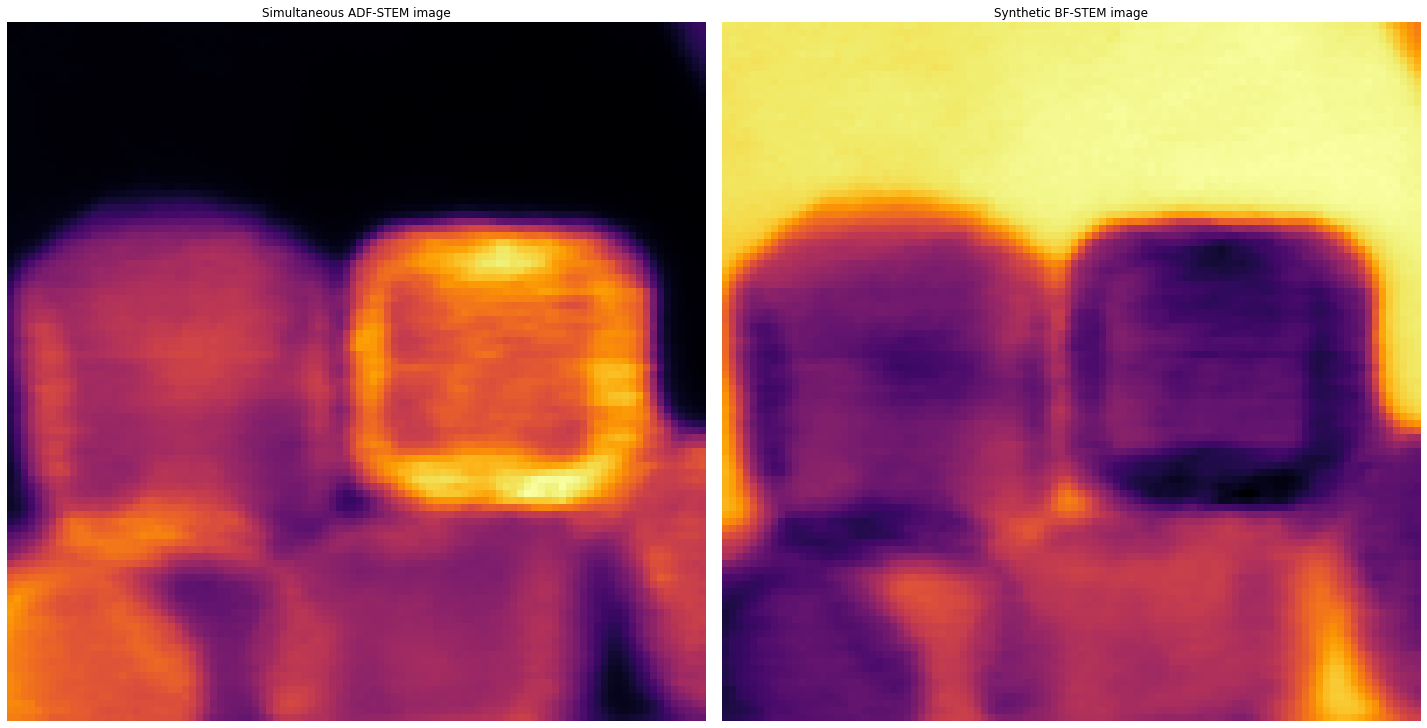

In [7]:
bf_stem = np.sum(Data_4D,axis=(0,1))
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(DataADF, cmap='inferno')
plt.axis('off')
plt.title('Simultaneous ADF-STEM image')
plt.subplot(1, 2, 2)
plt.imshow(bf_stem, cmap='inferno')
plt.axis('off')
plt.title('Synthetic BF-STEM image')

plt.tight_layout()

And also the mean CBED data.

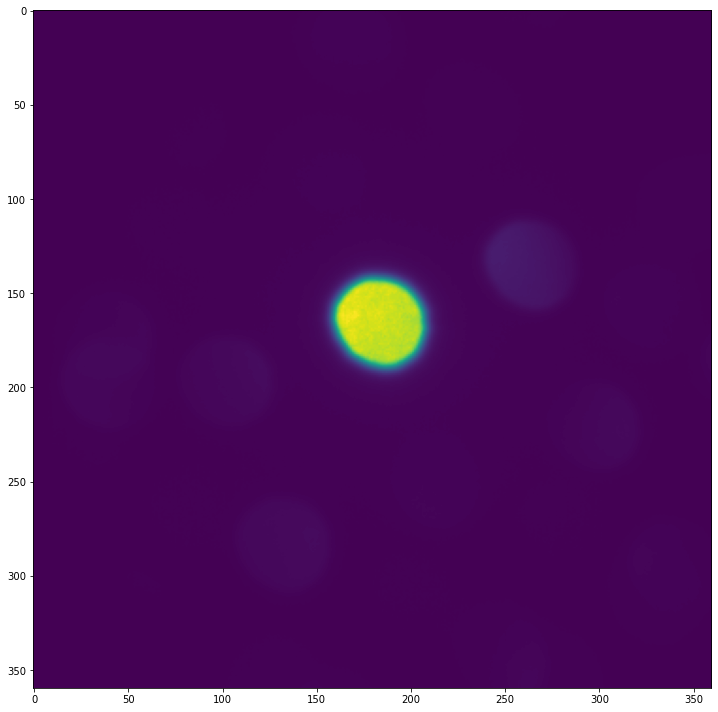

In [8]:
mean_cbed = np.sum(Data_4D, axis=(-1, -2))
plt.figure(figsize=(10, 10))
plt.imshow(mean_cbed)

plt.tight_layout()

In [9]:
%timeit st.nbed.bin4D(Data_4D[:,:,0:20,0:20],4)

431 ms ± 8.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
st.tic()
binned_4D = st.nbed.bin4D(Data_4D,4)
binned4D_2col = (st.nbed.data4Dto2D(binned_4D)).astype(np.float64)
st.toc()

Elapsed time: 8.856389 seconds.



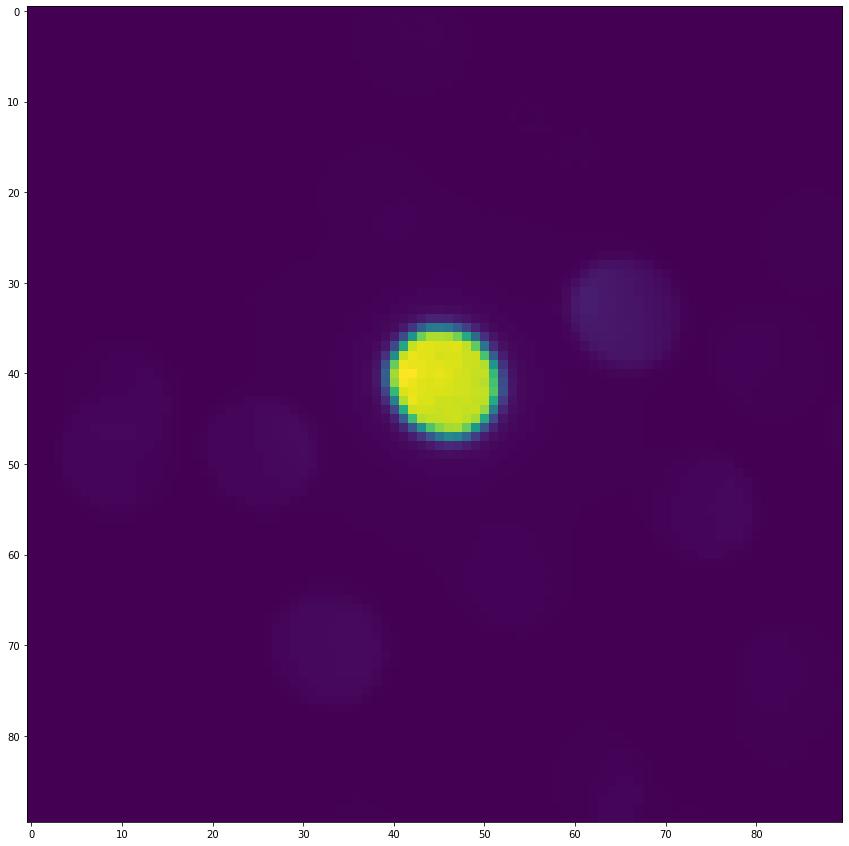

In [11]:
mean_binned_cbed = np.mean(binned_4D,axis=(2,3),dtype=np.float64)
plt.figure(figsize=(15,15))
plt.imshow(mean_binned_cbed)

Elapsed time: 0.367534 seconds.



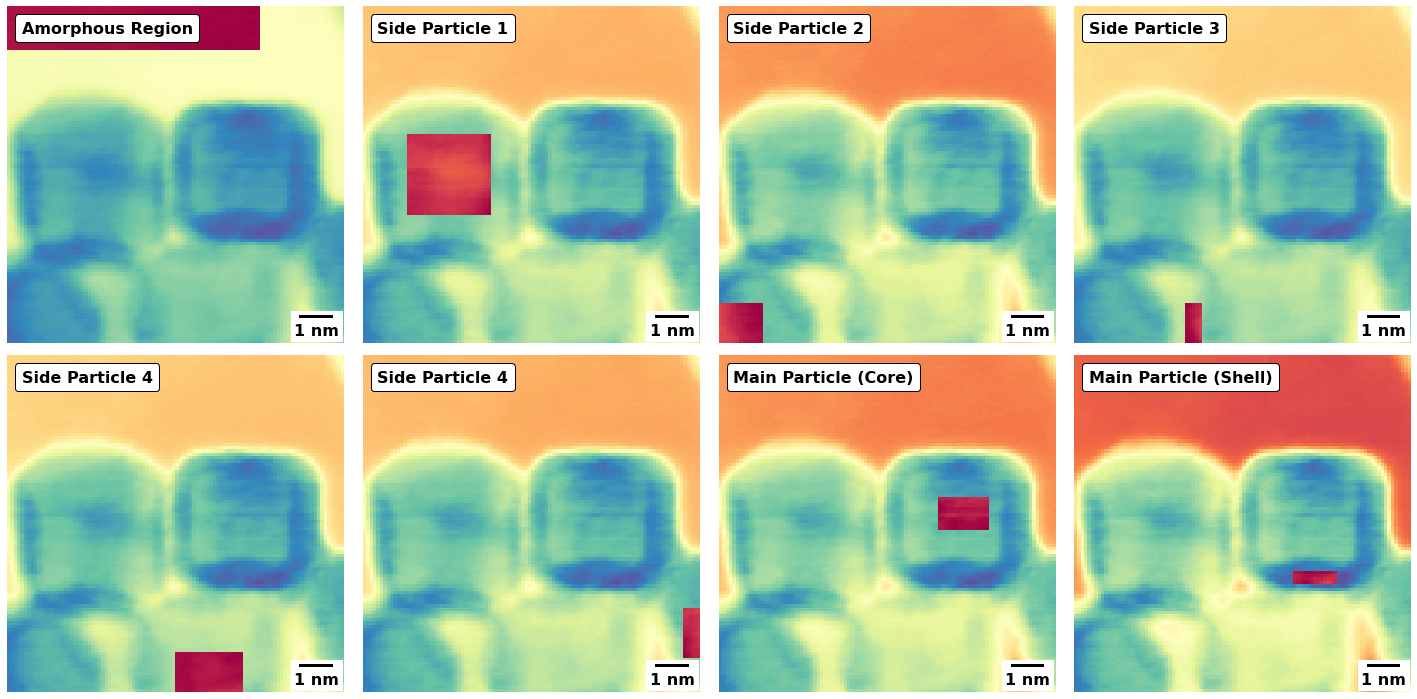

In [12]:
st.tic()
amorphous_r,amorphous_r_im = st.nbed.spectra_finder(binned_4D, (0, 13), (0, 75))
side_part_1,side_part_1_im = st.nbed.spectra_finder(binned_4D, (38, 62), (13, 38))
side_part_2,side_part_2_im = st.nbed.spectra_finder(binned_4D, (88, 200), (0, 13))
side_part_3,side_part_3_im = st.nbed.spectra_finder(binned_4D, (88, 200), (33, 38))
side_part_4,side_part_4_im = st.nbed.spectra_finder(binned_4D, (88, 100), (50, 70))
side_part_5,side_part_5_im = st.nbed.spectra_finder(binned_4D, (75, 90), (95, 100))
main_part_c,main_part_c_im = st.nbed.spectra_finder(binned_4D, (42, 52), (65, 80))
main_part_s,main_part_s_im = st.nbed.spectra_finder(binned_4D, (64, 68), (65, 78))
st.toc()

font_size = int(16)
sc_font={'weight' : 'bold',
         'size'   : font_size}
mpl.rc('font', **sc_font)
title_font = {'weight': 'bold',
              'size': int(1.2*font_size),
             }

plt.figure(figsize=(20,10))

plt.subplot(2,4,1)
plt.imshow(amorphous_r_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Amorphous Region',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,2)
plt.imshow(side_part_1_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 1',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,3)
plt.imshow(side_part_2_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 2',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,4)
plt.imshow(side_part_3_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 3',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,5)
plt.imshow(side_part_4_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 4',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,6)
plt.imshow(side_part_5_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 4',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,7)
plt.imshow(main_part_c_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Main Particle (Core)',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,8)
plt.imshow(main_part_s_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Main Particle (Shell)',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')
plt.tight_layout()

In [13]:
spectra = np.asarray((amorphous_r,
                      side_part_1,
                      side_part_2,
                      side_part_3,
                      side_part_4,
                      side_part_5,
                      main_part_c,
                      main_part_s))

In [14]:
binned4D_2col.shape, spectra.shape

((10000, 8100), (8, 8100))

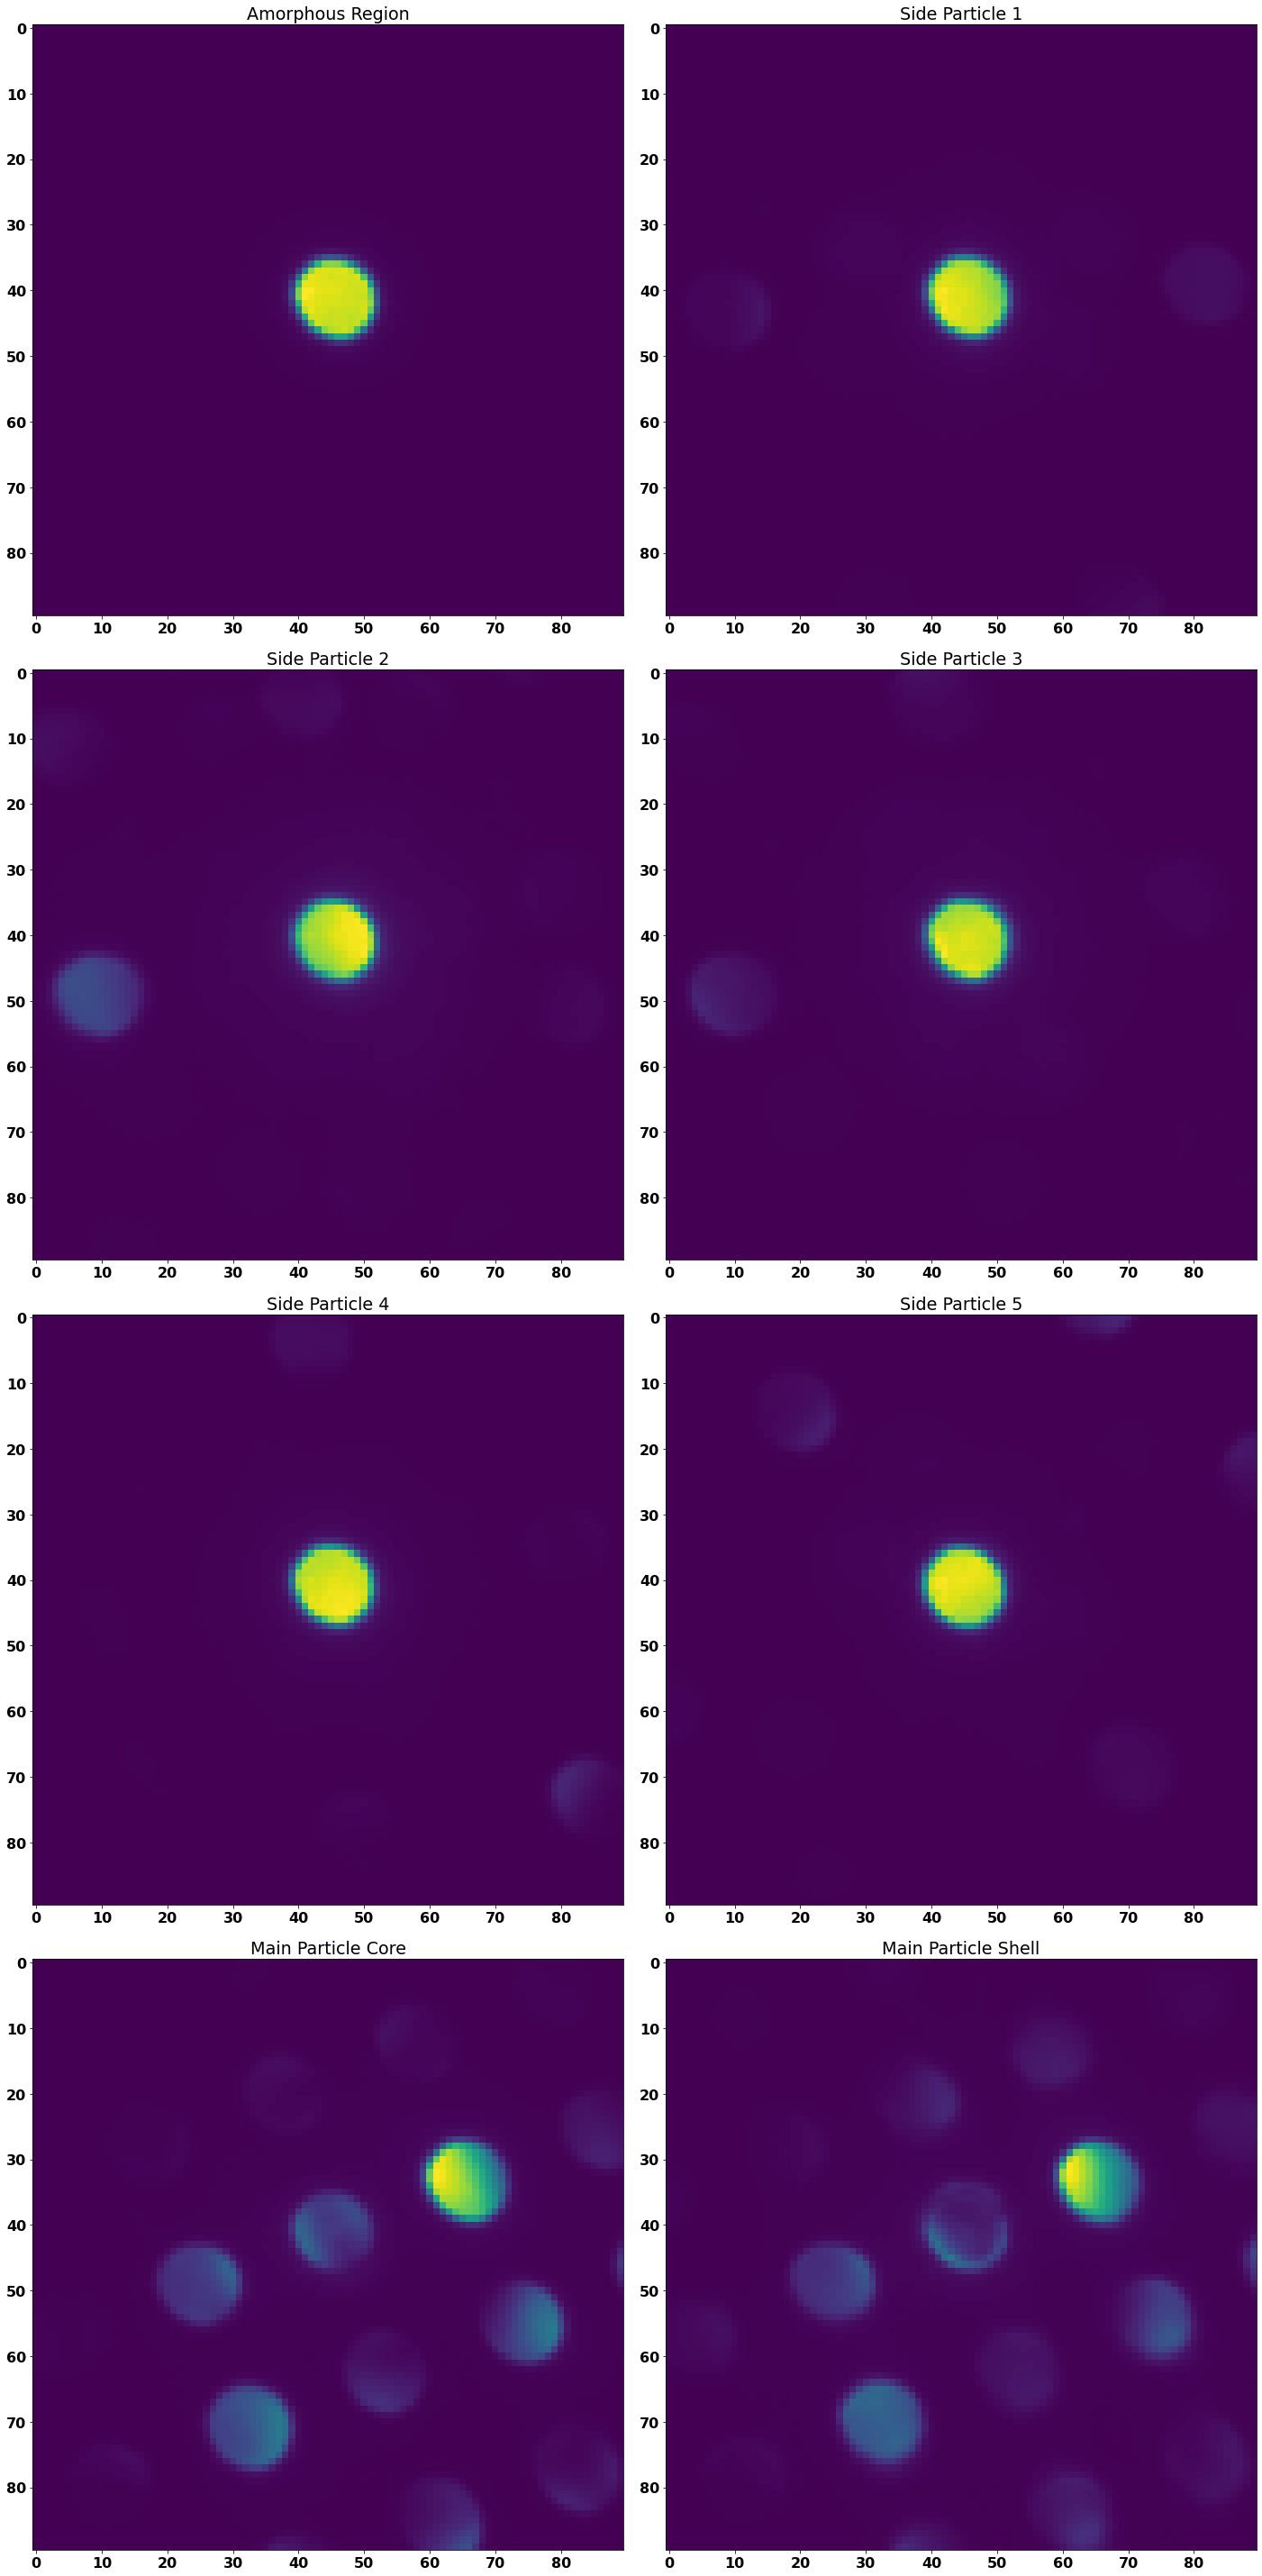

In [15]:
plt.figure(figsize=(20, 40))
plt.subplot(4,2,1)
plt.imshow(np.reshape(amorphous_r, mean_binned_cbed.shape))
plt.title('Amorphous Region')
plt.subplot(4,2,2)
plt.imshow(np.reshape(side_part_1, mean_binned_cbed.shape))
plt.title('Side Particle 1')
plt.subplot(4,2,3)
plt.imshow(np.reshape(side_part_2, mean_binned_cbed.shape))
plt.title('Side Particle 2')
plt.subplot(4,2,4)
plt.imshow(np.reshape(side_part_3, mean_binned_cbed.shape))
plt.title('Side Particle 3')
plt.subplot(4,2,5)
plt.imshow(np.reshape(side_part_4, mean_binned_cbed.shape))
plt.title('Side Particle 4')
plt.subplot(4,2,6)
plt.imshow(np.reshape(side_part_5, mean_binned_cbed.shape))
plt.title('Side Particle 5')
plt.subplot(4,2,7)
plt.imshow(np.reshape(main_part_c, mean_binned_cbed.shape))
plt.title('Main Particle Core')
plt.subplot(4,2,8)
plt.imshow(np.reshape(main_part_s, mean_binned_cbed.shape))
plt.title('Main Particle Shell')

plt.tight_layout()

In [16]:
help(st.nbed.log_sobel4D)

Help on CPUDispatcher in module stemtool.nbed.nbed_strain:

log_sobel4D(data4D, scan_dims, med_factor=30, gauss_val=3)
    Take the Log-Sobel of a pattern. 
    
    Parameters
    ----------
    data4D:     ndarray 
                4D dataset whose CBED patterns will be filtered
    scan_dims:  tuple
                Scan dimensions. If your scanning pixels are for 
                example the first two dimensions specify it as (0,1)
                Will be converted to numpy array so pass tuple only
    med_factor: float, optional
                Due to detector noise, some stray pixels may often 
                be brighter than the background. This is used for 
                damping any such pixels. Default is 30
    gauss_val:  float, optional
                The standard deviation of the Gaussian filter applied 
                to the logarithm of the CBED pattern. Default is 3
    
    Returns
    -------
    data_lsb: ndarray
              4D dataset where each CBED pattern ha

In [17]:
st.tic()
binned_4D_lsb = st.nbed.log_sobel4D(binned_4D, (-1, -2), 50, 0.5)
binned_4D_2lsb = (st.nbed.data4Dto2D(binned_4D_lsb)).astype(np.float)
st.toc()

Elapsed time: 33.480032 seconds.



Elapsed time: 0.669059 seconds.



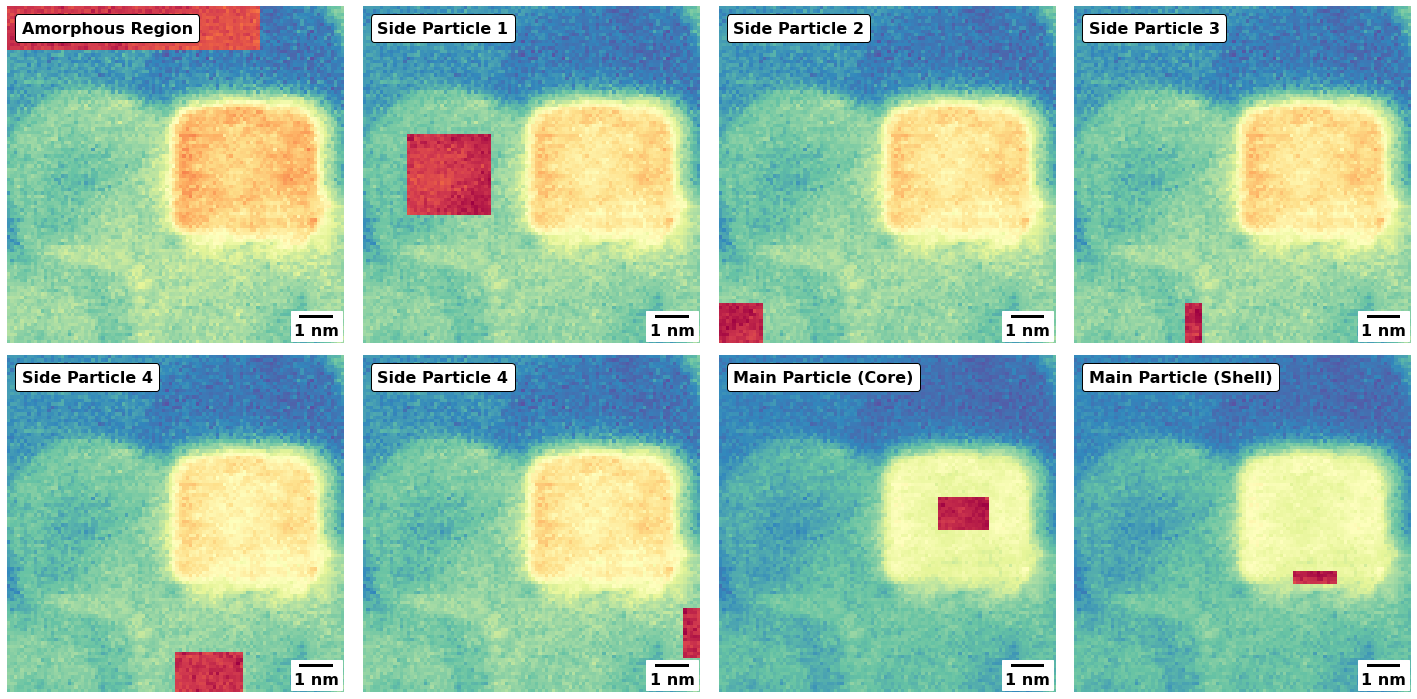

In [18]:
st.tic()
amorphous_r, amorphous_r_im = st.nbed.spectra_finder(binned_4D_lsb, (0, 13), (0, 75))
side_part_1, side_part_1_im = st.nbed.spectra_finder(binned_4D_lsb, (38, 62), (13, 38))
side_part_2, side_part_2_im = st.nbed.spectra_finder(binned_4D_lsb, (88, 200), (0, 13))
side_part_3, side_part_3_im = st.nbed.spectra_finder(binned_4D_lsb, (88, 200), (33, 38))
side_part_4, side_part_4_im = st.nbed.spectra_finder(binned_4D_lsb, (88, 100), (50, 70))
side_part_5, side_part_5_im = st.nbed.spectra_finder(binned_4D_lsb, (75, 90), (95, 100))
main_part_c, main_part_c_im = st.nbed.spectra_finder(binned_4D_lsb, (42, 52), (65, 80))
main_part_s, main_part_s_im = st.nbed.spectra_finder(binned_4D_lsb, (64, 68), (65, 78))
st.toc()

font_size = int(16)
sc_font={'weight' : 'bold',
         'size'   : font_size}
mpl.rc('font', **sc_font)
title_font = {'weight': 'bold',
              'size': int(1.2*font_size),
             }

plt.figure(figsize=(20,10))

plt.subplot(2,4,1)
plt.imshow(amorphous_r_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Amorphous Region',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,2)
plt.imshow(side_part_1_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 1',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,3)
plt.imshow(side_part_2_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 2',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,4)
plt.imshow(side_part_3_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 3',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,5)
plt.imshow(side_part_4_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 4',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,6)
plt.imshow(side_part_5_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 4',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,7)
plt.imshow(main_part_c_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Main Particle (Core)',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(2,4,8)
plt.imshow(main_part_s_im,cmap='Spectral_r')
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Main Particle (Shell)',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')
plt.tight_layout()

In [19]:
spectra = np.asarray((amorphous_r,
                      side_part_1,
                      side_part_2,
                      side_part_3,
                      side_part_4,
                      side_part_5,
                      main_part_c,
                      main_part_s))

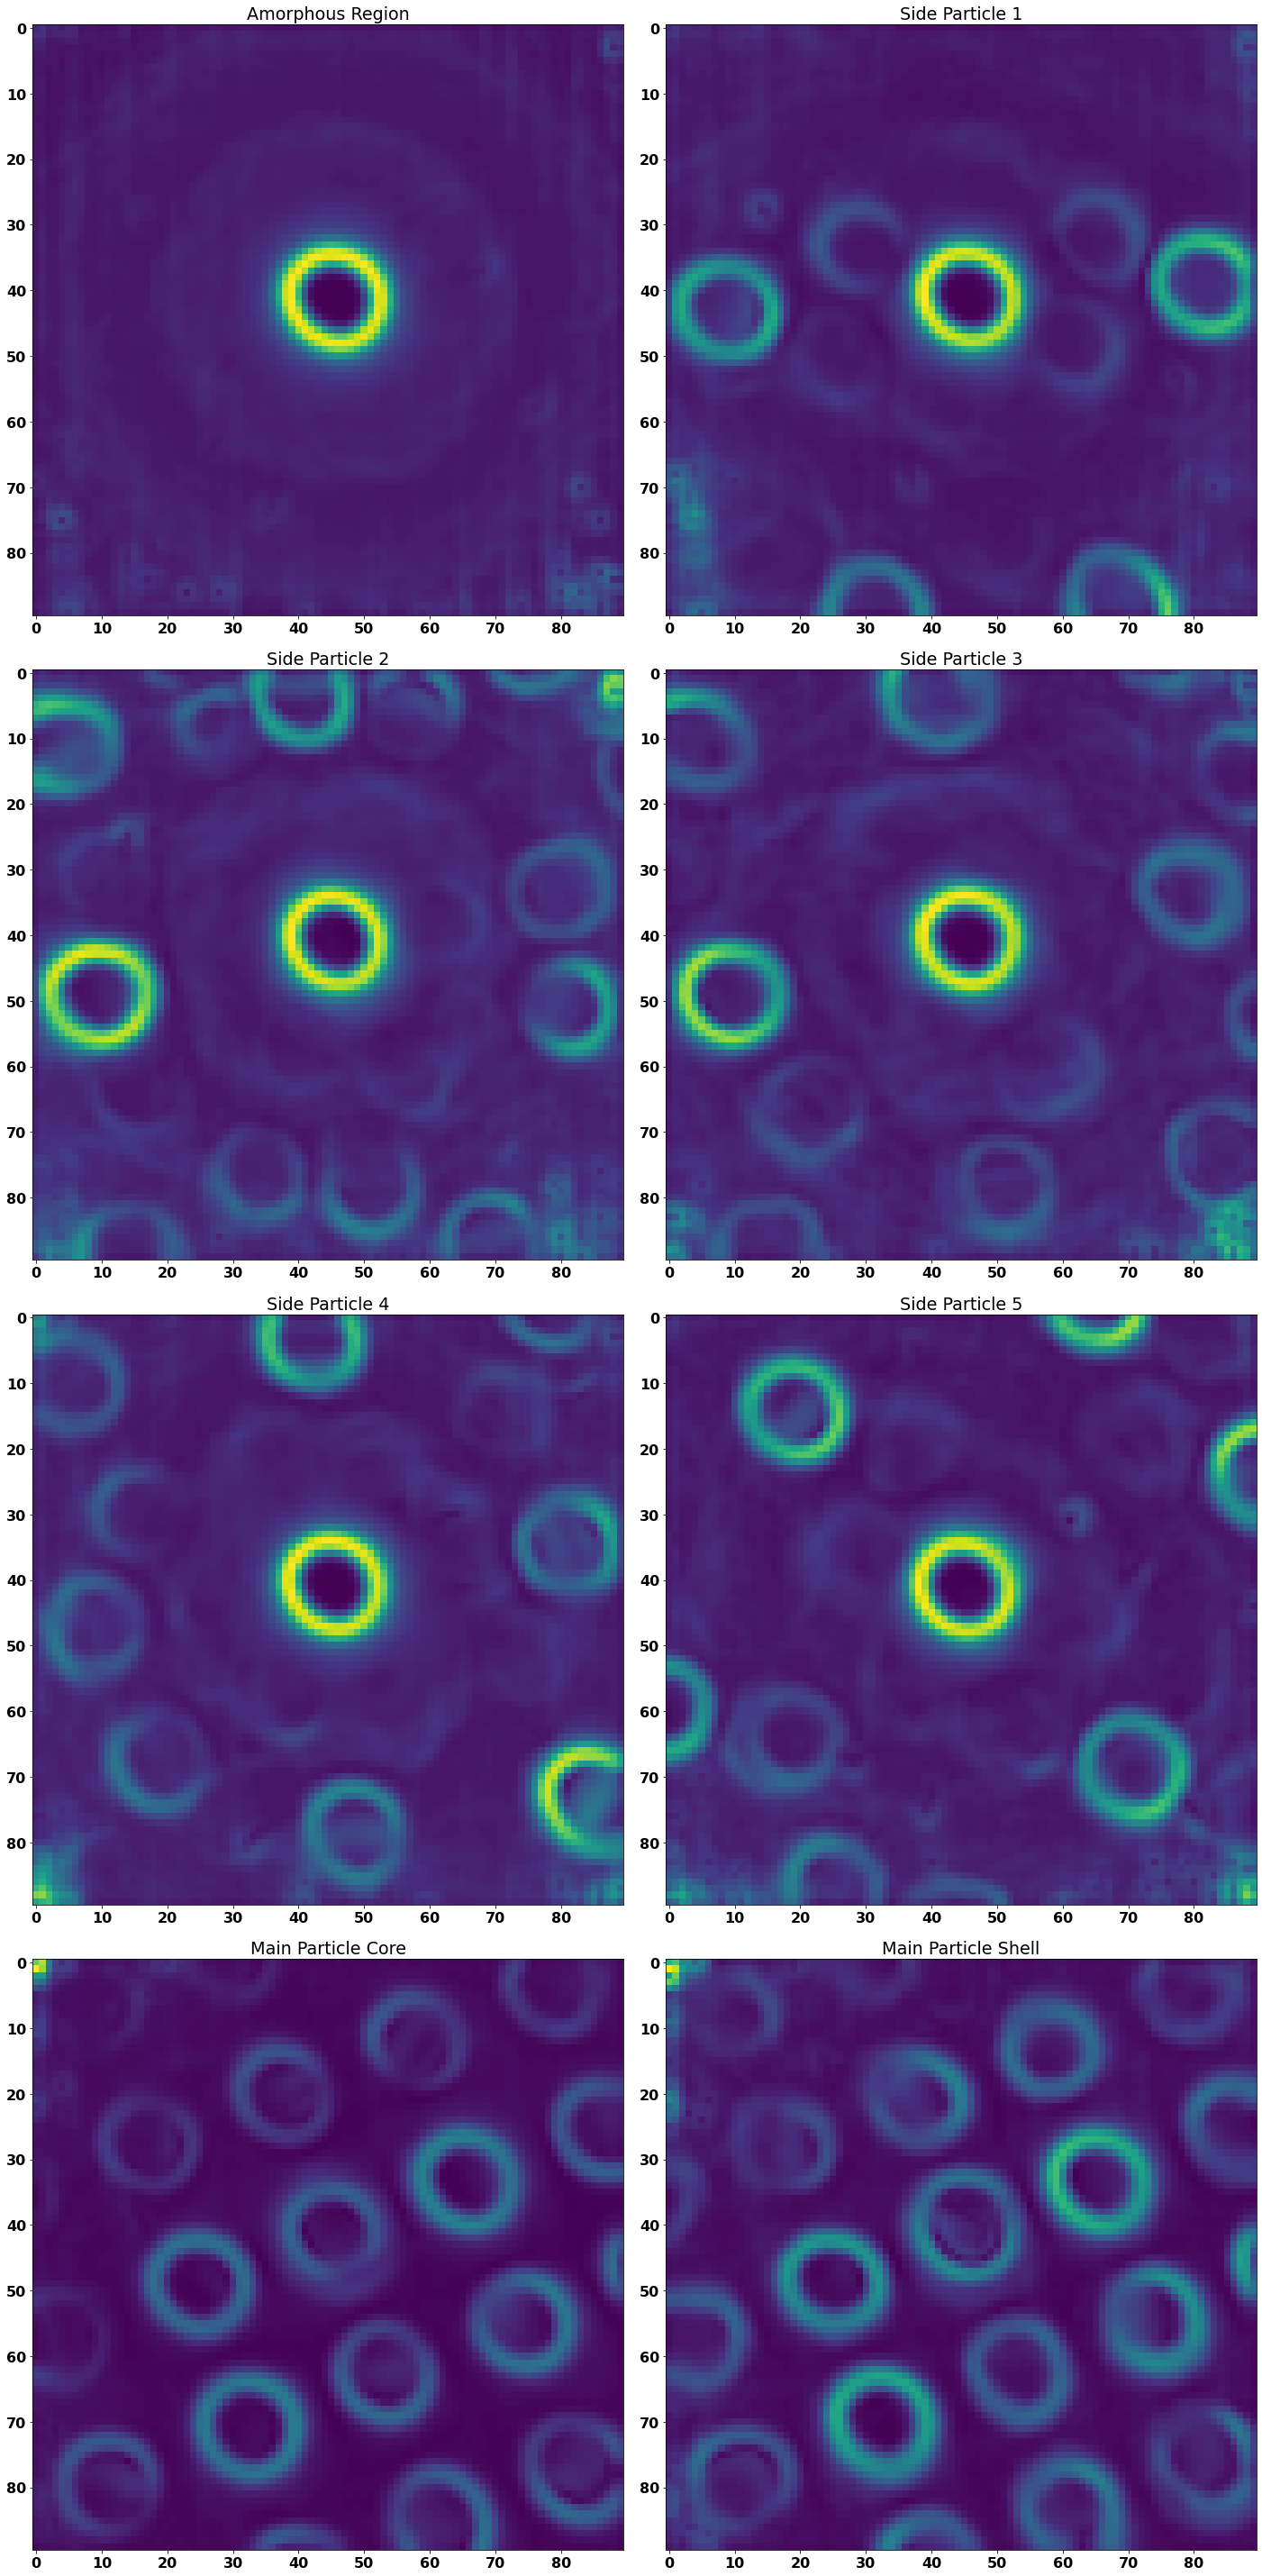

In [20]:
plt.figure(figsize=(20, 40))
plt.subplot(4,2,1)
plt.imshow(np.reshape(amorphous_r, mean_binned_cbed.shape))
plt.title('Amorphous Region')
plt.subplot(4,2,2)
plt.imshow(np.reshape(side_part_1, mean_binned_cbed.shape))
plt.title('Side Particle 1')
plt.subplot(4,2,3)
plt.imshow(np.reshape(side_part_2, mean_binned_cbed.shape))
plt.title('Side Particle 2')
plt.subplot(4,2,4)
plt.imshow(np.reshape(side_part_3, mean_binned_cbed.shape))
plt.title('Side Particle 3')
plt.subplot(4,2,5)
plt.imshow(np.reshape(side_part_4, mean_binned_cbed.shape))
plt.title('Side Particle 4')
plt.subplot(4,2,6)
plt.imshow(np.reshape(side_part_5, mean_binned_cbed.shape))
plt.title('Side Particle 5')
plt.subplot(4,2,7)
plt.imshow(np.reshape(main_part_c, mean_binned_cbed.shape))
plt.title('Main Particle Core')
plt.subplot(4,2,8)
plt.imshow(np.reshape(main_part_s, mean_binned_cbed.shape))
plt.title('Main Particle Shell')

plt.tight_layout()

In [25]:
mcrar = pymcr.mcr.McrAR(max_iter=50, st_regr='NNLS', 
                        c_regr=pymcr.regressors.OLS(), 
                        c_constraints=[pymcr.constraints.ConstraintNonneg(), 
                                       pymcr.constraints.ConstraintNorm()])

In [ ]:
st.tic()
mcrar.fit(binned_4D_2lsb, ST=spectra, verbose=True)
print('\nFinal MSE: {:.7e}'.format(mcrar.err[-1]))
st.toc()

In [ ]:
conc_profiles = mcrar.C_opt_
spec_profiles = mcrar.ST_opt_
amorphous_r_conc = np.reshape(conc_profiles[:,0], binned_4D.shape[2:4])
side_part_1_conc = np.reshape(conc_profiles[:,1], binned_4D.shape[2:4])
side_part_2_conc = np.reshape(conc_profiles[:,2], binned_4D.shape[2:4])
side_part_3_conc = np.reshape(conc_profiles[:,3], binned_4D.shape[2:4])
side_part_4_conc = np.reshape(conc_profiles[:,4], binned_4D.shape[2:4])
side_part_5_conc = np.reshape(conc_profiles[:,5], binned_4D.shape[2:4])
main_part_c_conc = np.reshape(conc_profiles[:,6], binned_4D.shape[2:4])
main_part_s_conc = np.reshape(conc_profiles[:,7], binned_4D.shape[2:4])
amorphous_r_spec = np.reshape(spec_profiles[0,:], binned_4D.shape[0:2])
side_part_1_spec = np.reshape(spec_profiles[1,:], binned_4D.shape[0:2])
side_part_2_spec = np.reshape(spec_profiles[2,:], binned_4D.shape[0:2])
side_part_3_spec = np.reshape(spec_profiles[3,:], binned_4D.shape[0:2])
side_part_4_spec = np.reshape(spec_profiles[4,:], binned_4D.shape[0:2])
side_part_5_spec = np.reshape(spec_profiles[5,:], binned_4D.shape[0:2])
main_part_c_spec = np.reshape(spec_profiles[6,:], binned_4D.shape[0:2])
main_part_s_spec = np.reshape(spec_profiles[7,:], binned_4D.shape[0:2])

In [ ]:
font_size = int(16)
sc_font={'weight' : 'bold',
         'size'   : font_size}
mpl.rc('font', **sc_font)
title_font = {'weight': 'bold',
              'size': int(1.2*font_size),
             }

plt.figure(figsize=(20,20))

plt.subplot(4,4,1)
plt.imshow(amorphous_r_conc,cmap=vl_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Amorphous Region',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,2)
plt.imshow(amorphous_r_spec,cmap=vl_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Amorphous Pattern',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,3)
plt.imshow(side_part_1_conc,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 1',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,4)
plt.imshow(side_part_1_spec,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 1 Pattern',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,5)
plt.imshow(side_part_2_conc,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 2',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,6)
plt.imshow(side_part_2_spec,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 2 Pattern',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,7)
plt.imshow(side_part_3_conc,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 3',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,8)
plt.imshow(side_part_3_spec,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 3 Pattern',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')


plt.subplot(4,4,9)
plt.imshow(side_part_4_conc,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 4',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,10)
plt.imshow(side_part_4_spec,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 4 Pattern',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,11)
plt.imshow(side_part_5_conc,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 4',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,12)
plt.imshow(side_part_5_spec,cmap=gr_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Side Particle 4 Pattern',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,13)
plt.imshow(main_part_c_conc,cmap=or_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Main Particle (Core)',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,14)
plt.imshow(main_part_c_spec,cmap=or_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Main Particle (Core) Pattern',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,15)
plt.imshow(main_part_s_conc,cmap=rd_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Main Particle (Shell)',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.subplot(4,4,16)
plt.imshow(main_part_s_spec,cmap=rd_cl)
scalebar = ScaleBar(scan_calib_vals,scan_calib_unit)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
plt.gca().add_artist(scalebar)
at = AnchoredText('Main Particle (Shell) Pattern',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
plt.gca().add_artist(at)
plt.axis('off')

plt.tight_layout()

In [ ]:
from skimage import feature as skfeat
particle_edge = st.util.image_normalizer(main_part_c_conc+main_part_s_conc)
particle_edge[particle_edge > 0.2] = 1
particle_edge[particle_edge < 0.2] = 0
particle_edge = particle_edge.astype(bool)
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(main_part_s_conc)
plt.subplot(1, 3, 2)
plt.imshow(main_part_c_conc)
plt.subplot(1, 3, 3)
plt.imshow(particle_edge, cmap='gray')

In [ ]:
nodiff_cbed = np.mean(Data_4D[:, :, 0:13, 0:50], axis=(-1, 2),dtype=np.float64)
plt.figure(figsize=(15, 15))
plt.imshow(nodiff_cbed)
plt.title('Diffraction Pattern on amorphous carbon')

In [ ]:
beam_x, beam_y, beam_r = st.util.sobel_circle(nodiff_cbed)
center_disk = st.util.make_circle(np.asarray(nodiff_cbed.shape), beam_x, beam_y, beam_r)
plt.figure(figsize=(30, 15))
plt.subplot(1,2,1)
plt.imshow(nodiff_cbed)
plt.subplot(1,2,2)
plt.imshow(center_disk)

In [ ]:
ROI_4D = Data_4D[:, :, particle_edge]

In [ ]:
Reference_Region = np.zeros_like(particle_edge)
Reference_Region[45:55, 65:75] = True
plt.figure(figsize=(10, 10))
plt.imshow(0.5*Reference_Region+st.util.image_normalizer(bf_stem),cmap='viridis')

In [ ]:
Reference_4D = Data_4D[:, :, Reference_Region]

In [ ]:
Mean_CBED_Reference = np.mean(Reference_4D,axis=-1,dtype=np.float64)
plt.figure(figsize=(30, 15))
plt.subplot(1,2,1)
plt.imshow(Mean_CBED_Reference,cmap='Spectral')
plt.title('Mean Diffraction Pattern from Reference')
plt.subplot(1,2,2)
plt.imshow(st.util.image_logarizer(Mean_CBED_Reference,16),cmap='Spectral')

In [ ]:
med_val = 50
center_disk = st.util.make_circle(np.asarray(nodiff_cbed.shape), beam_x, beam_y, beam_r)
sobel_center_disk,_ = st.util.sobel(center_disk)
sobel_lm_cbed,_ = st.util.sobel(scnd.gaussian_filter(st.util.image_logarizer(Mean_CBED_Reference),1))
sobel_lm_cbed[sobel_lm_cbed > med_val*np.median(sobel_lm_cbed)] = med_val*np.median(sobel_lm_cbed)
sobel_lm_cbed[sobel_lm_cbed < np.median(sobel_lm_cbed)/med_val] = np.median(sobel_lm_cbed)/med_val
lsc_reference = st.util.cross_corr(sobel_lm_cbed,sobel_center_disk,hybridizer=0.25)
plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
plt.imshow(sobel_lm_cbed,cmap='Spectral')
plt.title('Sobel of Log of Reference Pattern')
plt.subplot(1,3,2)
plt.imshow(sobel_center_disk,cmap='Spectral')
plt.title('Sobel of Central Disk')
plt.subplot(1,3,3)
plt.imshow(lsc_reference,cmap='Spectral')

In [ ]:
title_font = {'weight': 'bold',
              'size': 20,
             }

disk_pixel_list = np.asarray(((145, 95), 
                              (230, 65), 
                              (100, 210), 
                              (180, 180), 
                              (260, 150), 
                              (340, 120), 
                              (130, 300), 
                              (210, 270), 
                              (300, 240)), dtype=np.float64)
disk_value_list = np.asarray(((0, 2), 
                              (2, 2), 
                              (-2, 0), 
                              (0, 0), 
                              (2, 0), 
                              (4, 0), 
                              (-2, -2), 
                              (0, -2), 
                              (2, -2)), dtype=np.float64)
plt.figure(figsize=(30, 30))
for ii in range(9):
    plt.subplot(3, 3, ii+1)
    plt.imshow(st.util.image_normalizer(lsc_reference) + 
               st.util.make_circle(lsc_reference.shape, disk_pixel_list[ii, 0], disk_pixel_list[ii, 1], beam_r), cmap='terrain')
    at = AnchoredText(str(disk_pixel_list[ii, :]) + ' at ' + str(disk_value_list[ii, :]),
                  prop=dict(size=30), frameon=True,
                  loc='upper left',
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    plt.gca().add_artist(at)
    #plt.axis('off')
plt.tight_layout()

In [ ]:
%timeit st.nbed.fit_nbed_disks(lsc_reference, beam_r, disk_pixel_list, disk_value_list)

In [ ]:
st.tic()
reference_disk_list,reference_center,std,reference_axes = st.nbed.fit_nbed_disks(lsc_reference, 
                                                                                 beam_r, 
                                                                                 disk_pixel_list, 
                                                                                 disk_value_list)
_,_,log_std,log_axes = st.nbed.fit_nbed_disks(st.util.image_logarizer(Mean_CBED_Reference), 
                                              beam_r, 
                                              disk_pixel_list, 
                                              disk_value_list)
_,_,raw_std,raw_axes = st.nbed.fit_nbed_disks(Mean_CBED_Reference, 
                                              beam_r, 
                                              disk_pixel_list, 
                                              disk_value_list)
st.toc()

In [ ]:
plt.figure(figsize=(30, 30))
for ii in range(9):
    plt.subplot(3, 3, ii+1)
    plt.imshow(st.util.image_normalizer(lsc_reference) + 
               st.util.make_circle(lsc_reference.shape, 
                                   reference_disk_list[ii, 0], 
                                   reference_disk_list[ii, 1], 
                                   beam_r), 
               cmap='terrain')
    at = AnchoredText(str(disk_value_list[ii,:]),
                  prop=dict(size=30), frameon=True,
                  loc='upper left',
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    plt.gca().add_artist(at)
    plt.axis('off')
plt.tight_layout()

In [ ]:
np.sum(particle_edge)/np.sum(Reference_Region)

In [ ]:
st.tic()
st.nbed.strain_in_ROI(Data_4D, 
                      Reference_Region, 
                      center_disk, 
                      disk_pixel_list, 
                      disk_value_list, 
                      reference_axes, 
                      med_factor=40, 
                      nan_cutoff=0.5)
st.toc()

In [ ]:
st.tic()
e_xx_ROI, e_xy_ROI, e_th_ROI, e_yy_ROI, fit_data = st.nbed.strain_in_ROI(Data_4D, 
                                                                         particle_edge, 
                                                                         center_disk, 
                                                                         disk_pixel_list, 
                                                                         disk_value_list, 
                                                                         reference_axes, 
                                                                         med_factor=40, 
                                                                         nan_cutoff=0.5)
st.toc()

In [ ]:
st.nbed.strain_figure(exx=e_xx_ROI, 
                      exy=e_xy_ROI, 
                      eth=e_th_ROI, 
                      eyy=e_yy_ROI, 
                      ROI=particle_edge)